# Predict Humidity for Multiple Weather Parameters (Time Series Data)

The daily temperate, wind, rainfall and humidity of a location is recorded and noted in the input dataset from 1990~2020s. Build a time series model to predict the humidity in Y2021, given these features: temperate, wind, rainfall. 2020Q4 data can be used as test dataset, while the remaining for training the model. To verify the model, you can use any metric to compare prediction and actual humidity values in 2020Q4.

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import pacf
%matplotlib inline


import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [311]:
import tensorflow as tf 
tf.test.gpu_device_name() 

''

# Loading  Data

In [312]:
# Importing necessary modules
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Importing the statistics module
from statistics import mean
from statistics import median

# To load the input data
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot

# used to format headings 
bold = '\033[1m'
end = '\033[0m'
# Read the s&p 500 input data set and sorting based on date.
observed = pd.read_csv("observed_1.csv", index_col=False)

observed.head()


,date,temp,wind,rainfall,humidity
0,19900101,28.4000,17.9600,20.4000,32.1800
1,19900102,35.5000,2.2300,0.0000,22.8400
2,19900103,17.4000,9.0600,0.0000,29.3800
3,19900104,28.4000,1.5700,0.0000,26.3000
4,19900105,28.3000,0.3000,0.0000,26.7500


In [313]:
len(observed)
# observed['temp'] < 100

11231

# Data Filtering

In [314]:

observed_filtered = observed[observed['temp'] < 100] 
len(observed_filtered)

11127

In [315]:
from datetime import datetime
day_of_year = datetime.now().timetuple().tm_yday
day_of_year

130

In [316]:
# datetime.now()
date_time_obj = datetime.strptime("040205", '%y%m%d')
date_time_obj.timetuple().tm_yday

36

In [317]:
def convert_to_date(date):
    date_as_string = str(date)
    date_as_string = date_as_string[2:]
    date_time_obj = datetime.strptime(date_as_string, '%y%m%d')
    return date_time_obj
    
def convert_to_daynum(date):
    date_as_string = str(date)
    date_as_string = date_as_string[2:]
    date_time_obj = datetime.strptime(date_as_string, '%y%m%d')

    return date_time_obj.timetuple().tm_yday



observed_filtered['day'] = observed_filtered['date'].apply(convert_to_daynum)

observed_filtered['date'] = observed_filtered['date'].apply(convert_to_date)

In [318]:
observed_filtered.head()

,date,temp,wind,rainfall,humidity,day
0,1990-01-01,28.4000,17.9600,20.4000,32.1800,1
1,1990-01-02,35.5000,2.2300,0.0000,22.8400,2
2,1990-01-03,17.4000,9.0600,0.0000,29.3800,3
3,1990-01-04,28.4000,1.5700,0.0000,26.3000,4
4,1990-01-05,28.3000,0.3000,0.0000,26.7500,5


In [319]:
df = observed_filtered

# df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df['week'] = df['date'].apply(lambda x: x.week)
df['month'] = df['date'].apply(lambda x: x.month)
df['dayinmonth'] = df['date'].apply(lambda x: x.day)
df['humScale'] = df['temp'] * df['rainfall'] 

df.sort_values('date', inplace=True, ascending=True)
# df=df.loc[:,['date','year','quarter','month','dayinmonth', 'temp', 'wind', 'rainfall', 'day', 'humidity']]
df=df.loc[:,['week', 'temp', 'wind', 'rainfall', 'day', 'humScale', 'humidity']]
df = df.reset_index(drop=True)
df.head(10)

,week,temp,wind,rainfall,day,humScale,humidity
0,1,28.4000,17.9600,20.4000,1,579.3600,32.1800
1,1,35.5000,2.2300,0.0000,2,0.0000,22.8400
2,1,17.4000,9.0600,0.0000,3,0.0000,29.3800
3,1,28.4000,1.5700,0.0000,4,0.0000,26.3000
4,1,28.3000,0.3000,0.0000,5,0.0000,26.7500
5,1,35.4000,14.0400,0.0000,6,0.0000,20.7900
6,1,11.4000,5.6700,0.0000,7,0.0000,32.9600
7,2,29.5000,18.3600,0.0000,8,0.0000,21.8500
8,2,12.8000,19.2400,0.0000,9,0.0000,29.5500
9,2,32.2000,9.2700,0.0000,10,0.0000,22.7400


11127


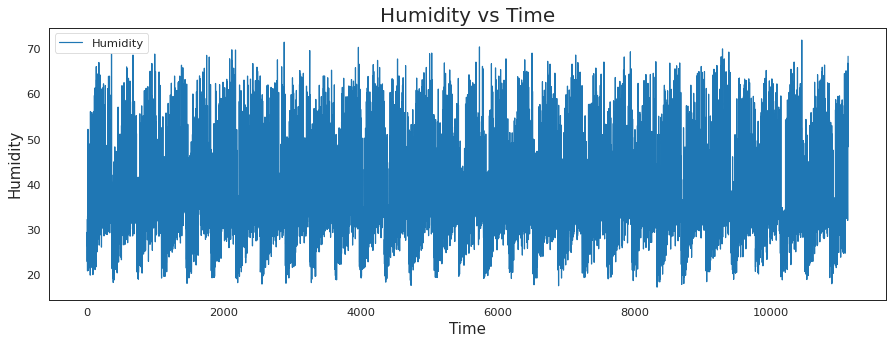

In [320]:
# Visualization Module - Humidity

humidity = df['humidity']
x = np.arange(0, len(humidity))
print(len(humidity))

plt.figure(figsize=(15,5))
plt.plot(x, humidity, label="Humidity")

plt.legend()
plt.title("Humidity vs Time", fontsize=20)
plt.ylabel("Humidity", fontsize=15)
plt.xlabel("Time", fontsize=15)
plt.show()


In [321]:

# normalize features
scalerOld = MinMaxScaler(feature_range=(0, 1))
reframed = pd.DataFrame(scalerOld.fit_transform(df))

# reframedValues = reframed.values

In [322]:

reframedValues = df.values
train_samples = int(0.9 * len(reframedValues))
print(train_samples)

train = reframedValues[:train_samples, :]
test = reframedValues[train_samples:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

10014
(10014, 6) (10014,) (1113, 6) (1113,)


# XgBoost based Implementation

In [323]:
from xgboost import XGBRegressor

model = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=3,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [325]:
y_pred = model.predict(test_X)
predictions = [value for value in y_pred]

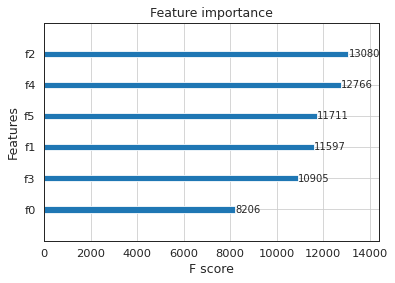

In [326]:
from xgboost import plot_importance

plot_importance(model)
pyplot.show()

In [328]:

print(test_y.size)
print(len(predictions))

# evaluate xgboost model using regression values
mean_squared_error(test_y, predictions)


1113
1113


0.1688461659045311

# Random Forest based Implementation

In [373]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(train_X, train_y)

RandomForestRegressor(random_state=0)

In [374]:
# Y_pred = regressor.predict(np.array([6.5]).reshape(1, 1))  # test the output by changing values


y_pred = regressor.predict(test_X)
predictions = [value for value in y_pred]

In [375]:
predictions

[38.72350000000004,
 47.56649999999997,
 30.490899999999996,
 27.765300000000007,
 58.70630000000003,
 28.268299999999986,
 42.2629,
 41.685100000000006,
 36.38139999999997,
 43.58139999999999,
 43.29410000000003,
 35.9571,
 36.124799999999986,
 59.1515,
 30.412700000000008,
 38.96909999999998,
 61.892199999999974,
 39.45760000000002,
 61.53030000000002,
 58.08949999999998,
 56.25199999999996,
 37.1713,
 58.53889999999999,
 55.80129999999996,
 36.828799999999994,
 57.469199999999965,
 49.376500000000014,
 38.39380000000001,
 29.26590000000001,
 50.6272,
 50.47590000000002,
 54.917400000000015,
 39.49900000000002,
 36.8316,
 37.216800000000035,
 37.19409999999997,
 28.672599999999992,
 34.93870000000003,
 36.104599999999984,
 45.5828,
 45.96720000000002,
 31.791299999999993,
 41.05909999999997,
 39.90679999999999,
 39.70470000000003,
 30.69459999999996,
 30.494299999999956,
 32.86000000000001,
 33.90749999999998,
 29.945799999999966,
 34.746100000000006,
 48.135099999999994,
 42.1100000

In [376]:
# print(test_y.size)
# print(len(predictions))

# evaluate model using regression values
mean_squared_error(test_y, predictions)

1113
1113


0.627979282066487

# 2020 Prediction

In [333]:

# Read the s&p 500 input data set and sorting based on date.
observed_2020 = pd.read_csv("test_input_1.csv", index_col=False)

observed_2020.head()

,date,temp,wind,rainfall
0,20201001,30.1000,16.7600,0.0000
1,20201002,24.7000,18.6800,30.9000
2,20201003,30.0000,5.3400,13.9000
3,20201004,23.7000,10.9500,0.0000
4,20201005,27.4000,4.4200,0.0000


In [334]:

observed_2020['day'] = observed_2020['date'].apply(convert_to_daynum)

observed_2020['date'] = observed_2020['date'].apply(convert_to_date)

In [335]:
df = observed_2020

# df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df['week'] = df['date'].apply(lambda x: x.week)
df['month'] = df['date'].apply(lambda x: x.month)
df['dayinmonth'] = df['date'].apply(lambda x: x.day)

df['humScale'] = df['temp'] * df['rainfall']

df.sort_values('date', inplace=True, ascending=True)
# df=df.loc[:,['date','year','quarter','month','dayinmonth', 'temp', 'wind', 'rainfall', 'day', 'humidity']]
df=df.loc[:,['week', 'temp', 'wind', 'rainfall', 'day', 'humScale']]

df = df.reset_index(drop=True)
df.head()

,week,temp,wind,rainfall,day,humScale
0,40,30.1000,16.7600,0.0000,275,0.0000
1,40,24.7000,18.6800,30.9000,276,763.2300
2,40,30.0000,5.3400,13.9000,277,417.0000
3,40,23.7000,10.9500,0.0000,278,0.0000
4,41,27.4000,4.4200,0.0000,279,0.0000


In [336]:
y_pred = model.predict(df.values)
predictions = [value for value in y_pred]

In [338]:
# Rearranging the predictions for 2020Q4
predictions = np.array(predictions).reshape(92, -1)

print(predictions.shape)

(92, 1)


In [339]:

# Read the input data set to get actual humidity values to compare with prediction
output_2020 = pd.read_csv("test_output_1.csv", index_col=False)

output_2020.head(10)

,date,humidity
0,20201001,31.2900
1,20201002,47.7500
2,20201003,40.6100
3,20201004,35.0200
4,20201005,35.4100
5,20201006,31.5900
6,20201007,42.4600
7,20201008,65.4000
8,20201009,34.6400
9,20201010,48.6100


In [340]:
output_2020['humidity'].values

array([31.29, 47.75, 40.61, 35.02, 35.41, 31.59, 42.46, 65.4 , 34.64,
       48.61, 43.02, 57.72, 38.63, 37.04, 37.3 , 33.52, 34.01, 40.49,
       28.1 , 30.26, 34.81, 29.01, 34.48, 34.16, 37.69, 42.83, 29.66,
       44.36, 38.44, 28.85, 27.89, 42.83, 32.84, 27.73, 38.41, 37.66,
       41.86, 38.19, 61.67, 34.65, 54.75, 35.57, 51.06, 44.62, 38.22,
       54.04, 41.44, 35.86, 43.07, 34.46, 34.57, 45.52, 40.59, 34.22,
       36.4 , 59.79, 44.05, 39.68, 29.65, 34.49, 38.43, 41.22, 54.06,
       37.13, 36.56, 35.29, 38.2 , 28.29, 33.15, 34.49, 57.48, 41.61,
       41.57, 32.91, 45.79, 57.77, 37.57, 43.88, 39.45, 36.27, 45.88,
       37.76, 38.66, 37.34, 33.98, 33.85, 32.99, 43.97, 38.32, 40.95,
       30.78, 36.32])

In [341]:

print(test_y.size)
print(len(predictions))

# evaluate predictions
actual_humidity = output_2020['humidity'].values
mean_squared_error(actual_humidity, predictions)


1113
92


0.14937119506949365

In [343]:
predictions = predictions.tolist()
flat_list = [item for sublist in predictions for item in sublist]
flat_list

[30.952869415283203,
 48.447044372558594,
 40.485260009765625,
 35.26887512207031,
 35.24127960205078,
 31.785354614257812,
 42.27786636352539,
 65.83169555664062,
 34.32491683959961,
 48.12773895263672,
 42.889854431152344,
 57.742305755615234,
 38.55887985229492,
 37.09360122680664,
 37.60514831542969,
 33.56056213378906,
 33.382572174072266,
 40.93805694580078,
 28.274993896484375,
 30.12407684326172,
 34.66828155517578,
 29.371583938598633,
 34.23849868774414,
 33.932064056396484,
 37.99378204345703,
 43.1566047668457,
 29.868629455566406,
 44.60145568847656,
 38.317710876464844,
 28.728178024291992,
 29.104175567626953,
 42.40011978149414,
 32.637271881103516,
 28.069326400756836,
 38.93256378173828,
 38.259666442871094,
 41.113250732421875,
 38.042362213134766,
 62.04999542236328,
 34.72975540161133,
 54.72578811645508,
 35.04850769042969,
 50.8032341003418,
 44.33037185668945,
 37.8747673034668,
 54.81845474243164,
 41.618595123291016,
 36.088497161865234,
 43.74854278564453,
 3

# 2021 Prediction

In [361]:

# Read the s&p 500 input data set and sorting based on date.
observed_2021 = pd.read_csv("forecasted_1.csv", index_col=False)

# saving date to concatenate with humidity later
observed_2021_dates = observed_2021["date"] 
observed_2021.head()

,date,temp,wind,rainfall
0,20210101,15.7500,6.1700,0.0000
1,20210102,19.1000,2.4950,66.6000
2,20210103,6.9000,9.2800,99.6000
3,20210104,5.6000,6.7850,0.0000
4,20210105,9.0000,5.8500,0.0000


In [362]:

observed_2021['day'] = observed_2021['date'].apply(convert_to_daynum)

observed_2021['date'] = observed_2021['date'].apply(convert_to_date)

In [363]:
df = observed_2021

# df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year)
df['week'] = df['date'].apply(lambda x: x.week)
df['month'] = df['date'].apply(lambda x: x.month)
df['dayinmonth'] = df['date'].apply(lambda x: x.day)
df['humScale'] = df['temp'] * df['rainfall'] 

df.sort_values('date', inplace=True, ascending=True)
# df=df.loc[:,['date','year','quarter','month','dayinmonth', 'temp', 'wind', 'rainfall', 'day', 'humidity']]
df=df.loc[:,['week', 'temp', 'wind', 'rainfall', 'day', 'humScale']]

df = df.reset_index(drop=True)
df.head()

,week,temp,wind,rainfall,day,humScale
0,53,15.7500,6.1700,0.0000,1,0.0000
1,53,19.1000,2.4950,66.6000,2,1272.0600
2,53,6.9000,9.2800,99.6000,3,687.2400
3,1,5.6000,6.7850,0.0000,4,0.0000
4,1,9.0000,5.8500,0.0000,5,0.0000


In [364]:
y_pred = model.predict(df.values)
predictions_xgboost = [value for value in y_pred]

In [365]:
predictions_xgboost

[30.770815,
 35.07496,
 38.161476,
 33.933773,
 33.518314,
 32.571445,
 36.883385,
 38.94313,
 32.15653,
 33.355385,
 32.00799,
 42.17798,
 30.515223,
 33.403778,
 32.976593,
 33.64754,
 33.199463,
 37.92369,
 33.122036,
 32.74894,
 33.26075,
 35.051746,
 33.18864,
 34.01323,
 48.14681,
 31.67995,
 30.691254,
 33.94529,
 33.949425,
 31.005062,
 34.778725,
 49.041943,
 35.993614,
 40.272793,
 34.357895,
 62.509018,
 33.743412,
 32.54897,
 35.69392,
 34.761612,
 33.562145,
 38.95348,
 30.31722,
 31.896618,
 33.348053,
 33.853542,
 32.54135,
 34.776398,
 33.868717,
 32.083992,
 32.733364,
 32.715023,
 38.98697,
 33.124966,
 32.130478,
 32.118298,
 42.121536,
 33.554855,
 33.785282,
 35.428997,
 32.43983,
 32.618305,
 33.49507,
 33.682903,
 32.89229,
 48.921013,
 36.748283,
 35.60899,
 32.87669,
 32.859135,
 34.45218,
 31.910997,
 36.857098,
 35.14367,
 33.514824,
 43.449757,
 36.380013,
 36.542355,
 40.988,
 58.374947,
 36.605774,
 35.040848,
 34.708553,
 35.684864,
 39.75461,
 32.574184,

In [366]:
observed_2021["date"]

0     2021-01-01
1     2021-01-02
2     2021-01-03
3     2021-01-04
4     2021-01-05
         ...    
360   2021-12-27
361   2021-12-28
362   2021-12-29
363   2021-12-30
364   2021-12-31
Name: date, Length: 365, dtype: datetime64[ns]

In [367]:
#concatenating for output
preds = np.array(predictions).reshape(365, -1)
dates = np.array(observed_2021_dates).reshape(365, -1)

print(dates.shape)
print(preds.shape)
result = np.concatenate((dates, preds), axis=1)

(365, 1)
(365, 1)


In [368]:
# pd.write_csv(result)
result = pd.DataFrame(result)
result.to_csv('result.csv', index=False)  

# Random Forest based Implementation

In [369]:

y_pred = regressor.predict(df.values)
predictions_rf = [value for value in y_pred]

In [370]:
predictions_rf

[31.017400000000023,
 51.67060000000002,
 54.193800000000046,
 33.21799999999999,
 33.22049999999999,
 32.42859999999999,
 48.02430000000001,
 49.68090000000004,
 32.23550000000001,
 32.700000000000024,
 32.2314,
 41.97270000000001,
 29.850099999999998,
 33.23249999999999,
 32.74300000000002,
 33.245699999999964,
 32.9972,
 49.88470000000003,
 33.016400000000004,
 32.72040000000002,
 33.063300000000005,
 34.50630000000003,
 33.19050000000001,
 33.58779999999999,
 49.41749999999999,
 30.565399999999986,
 31.185199999999988,
 33.76429999999999,
 33.56059999999998,
 31.248199999999983,
 34.71310000000004,
 50.275200000000005,
 35.43620000000003,
 50.63180000000003,
 34.006400000000006,
 61.186400000000056,
 33.65300000000003,
 32.44230000000003,
 35.22929999999996,
 34.489799999999995,
 33.243300000000005,
 49.687600000000046,
 30.512799999999984,
 31.887499999999978,
 33.10149999999997,
 33.998999999999995,
 32.80249999999996,
 34.658,
 34.18490000000001,
 32.060900000000004,
 32.8454999

In [372]:
print(test_y.size)
print(len(predictions))
# evaluate model using regression values
mean_squared_error(predictions_xgboost, predictions_rf)

1113
365


40.235017335691126

There is some deviation in regression values produced by xgboost and random forest. The prediction of xgboost is found to be better than random forest. But for sake of simplicity, we may adopt to implement Random Forest in Spark.

*Reason: Random Forest is trivially parallelizable while xgboost is not.*